In [1]:
# https://deeplearningcourses.com/c/deep-learning-convolutional-neural-networks-theano-tensorflow
# https://udemy.com/deep-learning-convolutional-neural-networks-theano-tensorflow
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
%matplotlib inline
import os
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from scipy.io import loadmat
from sklearn.utils import shuffle

from datetime import datetime

In [2]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


def error_rate(p, t):
    return np.mean(p != t)


def flatten(X):
    # input will be (32, 32, 3, N)
    # output will be (N, 3072)
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat

def get_data():
    if not os.path.exists('cnn_data/train_32x32.mat'):
        print('Looking for cnn_data/train_32x32.mat')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: http://ufldl.stanford.edu/housenumbers')
        print('Place train_32x32.mat and test_32x32.mat in the folder large_files adjacent to the class folder')
        exit()

    train = loadmat('cnn_data/train_32x32.mat')
    test  = loadmat('cnn_data/test_32x32.mat')
    return train, test


In [3]:
def relu(a):
    return a * (a > 0)


def convpool(X, W, b, poolsize=(2, 2)):
    conv_out = conv2d(input=X, filters=W)

    # downsample each feature map individually, using maxpooling
    pooled_out = pool.pool_2d(
        input=conv_out,
        ws=poolsize,
        ignore_border=True
    )

    # add the bias term. Since the bias is a vector (1D array), we first
    # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
    # thus be broadcasted across mini-batches and feature map
    # width & height
    # return T.tanh(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))
    return relu(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)


def rearrange(X):
    # input is (32, 32, 3, N)
    # output is (N, 3, 32, 32)
    # N = X.shape[-1]
    # out = np.zeros((N, 3, 32, 32), dtype=np.float32)
    # for i in range(N):
    #     for j in range(3):
    #         out[i, j, :, :] = X[:, :, j, i]
    # return out / 255
    return (X.transpose(3, 2, 0, 1) / 255).astype(np.float32)

In [4]:
# step 1: load the data, transform as needed
train, test = get_data()

# Need to scale! don't leave as 0..255
# Y is a N x 1 matrix with values 1..10 (MATLAB indexes by 1)
# So flatten it and make it 0..9
# Also need indicator matrix for cost calculation
Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest  = rearrange(test['X'])
Ytest  = test['y'].flatten() - 1
del test
Ytest_ind  = y2indicator(Ytest)

In [5]:
max_iter = 8
print_period = 10

lr = np.float32(0.00001)
reg = np.float32(0.01)
mu = np.float32(0.99)

N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

M = 500
K = 10
poolsz = (2, 2)

In [6]:
# after conv will be of dimension 32 - 5 + 1 = 28
# after downsample 28 / 2 = 14
W1_shape = (20, 3, 5, 5) # (num_feature_maps, num_color_channels, filter_width, filter_height)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[0], dtype=np.float32) # one bias per output feature map

# after conv will be of dimension 14 - 5 + 1 = 10
# after downsample 10 / 2 = 5
W2_shape = (50, 20, 5, 5) # (num_feature_maps, old_num_feature_maps, filter_width, filter_height)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[0], dtype=np.float32)

# vanilla ANN weights
W3_init = np.random.randn(W2_shape[0]*5*5, M) / np.sqrt(W2_shape[0]*5*5 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [7]:
# step 2: define theano variables and expressions
X = T.tensor4('X', dtype='float32')
Y = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init.astype(np.float32), 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init.astype(np.float32), 'W4')
b4 = theano.shared(b4_init, 'b4')

# momentum changes
dW1 = theano.shared(np.zeros(W1_init.shape, dtype=np.float32), 'dW1')
db1 = theano.shared(np.zeros(b1_init.shape, dtype=np.float32), 'db1')
dW2 = theano.shared(np.zeros(W2_init.shape, dtype=np.float32), 'dW2')
db2 = theano.shared(np.zeros(b2_init.shape, dtype=np.float32), 'db2')
dW3 = theano.shared(np.zeros(W3_init.shape, dtype=np.float32), 'dW3')
db3 = theano.shared(np.zeros(b3_init.shape, dtype=np.float32), 'db3')
dW4 = theano.shared(np.zeros(W4_init.shape, dtype=np.float32), 'dW4')
db4 = theano.shared(np.zeros(b4_init.shape, dtype=np.float32), 'db4')

# forward pass
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = T.nnet.softmax( Z3.dot(W4) + b4)

# define the cost function and prediction
params = (W1, b1, W2, b2, W3, b3, W4, b4)
reg_cost = reg*np.sum((param*param).sum() for param in params)
cost = -(Y * T.log(pY)).sum() + reg_cost
prediction = T.argmax(pY, axis=1)

In [8]:
# step 3: training expressions and functions
update_W1 = W1 + mu*dW1 - lr*T.grad(cost, W1)
update_b1 = b1 + mu*db1 - lr*T.grad(cost, b1)
update_W2 = W2 + mu*dW2 - lr*T.grad(cost, W2)
update_b2 = b2 + mu*db2 - lr*T.grad(cost, b2)
update_W3 = W3 + mu*dW3 - lr*T.grad(cost, W3)
update_b3 = b3 + mu*db3 - lr*T.grad(cost, b3)
update_W4 = W4 + mu*dW4 - lr*T.grad(cost, W4)
update_b4 = b4 + mu*db4 - lr*T.grad(cost, b4)

# update weight changes
update_dW1 = mu*dW1 - lr*T.grad(cost, W1)
update_db1 = mu*db1 - lr*T.grad(cost, b1)
update_dW2 = mu*dW2 - lr*T.grad(cost, W2)
update_db2 = mu*db2 - lr*T.grad(cost, b2)
update_dW3 = mu*dW3 - lr*T.grad(cost, W3)
update_db3 = mu*db3 - lr*T.grad(cost, b3)
update_dW4 = mu*dW4 - lr*T.grad(cost, W4)
update_db4 = mu*db4 - lr*T.grad(cost, b4)

In [9]:
train = theano.function(
    inputs=[X, Y],
    updates=[
        (W1, update_W1),
        (b1, update_b1),
        (W2, update_W2),
        (b2, update_b2),
        (W3, update_W3),
        (b3, update_b3),
        (W4, update_W4),
        (b4, update_b4),
        (dW1, update_dW1),
        (db1, update_db1),
        (dW2, update_dW2),
        (db2, update_db2),
        (dW3, update_dW3),
        (db3, update_db3),
        (dW4, update_dW4),
        (db4, update_db4),
    ],
)

In [10]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[X, Y],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0: 59948.324 / 0.919
Cost / err at iteration i=0, j=10: 58720.164 / 0.804
Cost / err at iteration i=0, j=20: 58520.205 / 0.804
Cost / err at iteration i=0, j=30: 58246.433 / 0.799
Cost / err at iteration i=0, j=40: 58397.657 / 0.804
Cost / err at iteration i=0, j=50: 57988.598 / 0.804
Cost / err at iteration i=0, j=60: 58070.428 / 0.804
Cost / err at iteration i=0, j=70: 57939.358 / 0.804
Cost / err at iteration i=0, j=80: 58098.671 / 0.804
Cost / err at iteration i=0, j=90: 57986.856 / 0.804
Cost / err at iteration i=0, j=100: 57838.552 / 0.804
Cost / err at iteration i=0, j=110: 57739.908 / 0.804
Cost / err at iteration i=0, j=120: 57618.524 / 0.804
Cost / err at iteration i=0, j=130: 57490.916 / 0.804
Cost / err at iteration i=0, j=140: 57338.009 / 0.804
Cost / err at iteration i=1, j=0: 57167.169 / 0.799
Cost / err at iteration i=1, j=10: 56836.846 / 0.767
Cost / err at iteration i=1, j=20: 56362.341 / 0.763
Cost / err at iteration i=1, j=30: 55640.35

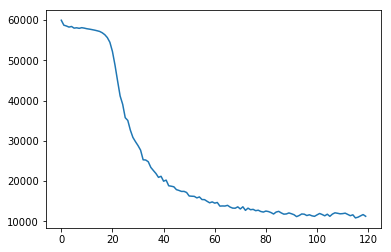

In [11]:
t0 = datetime.now()
LL = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            # cost_val = 0
            # err = 0 ### test
            print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
            LL.append(cost_val)
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()



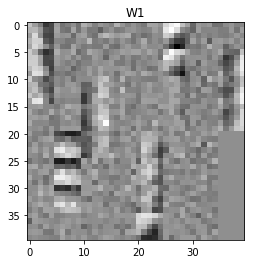

In [12]:
# visualize W1 (20, 3, 5, 5)
W1_val = W1.get_value()
grid = np.zeros((8*5, 8*5))
m = 0
n = 0
for i in range(20):
    for j in range(3):
        filt = W1_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 8:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W1")
plt.show()


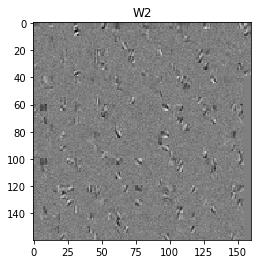

In [13]:
# visualize W2 (50, 20, 5, 5)
W2_val = W2.get_value()
grid = np.zeros((32*5, 32*5))
m = 0
n = 0
for i in range(50):
    for j in range(20):
        filt = W2_val[i,j]
        grid[m*5:(m+1)*5,n*5:(n+1)*5] = filt
        m += 1
        if m >= 32:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W2")
plt.show()